In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn import metrics


In [2]:
#Goal to classify most used words w/positive and negative reviews

#importing dataframe


df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [25]:
#changing sentiment from positive to be 1 and negative to 0

label_encoder = preprocessing.LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment,word count
0,one of the other reviewers has mentioned that ...,1,307
1,a wonderful little production the filming tech...,1,162
2,i thought this was a wonderful way to spend ti...,1,166
3,basically theres a family where a little boy j...,0,138
4,petter matteis love in the time of money is a ...,1,230


In [26]:
#Counting amount of positive and negative reviews

df.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [27]:
#getting word count for pos/neg reviews

def word_count(review):
    return(len(review.split()))

df['word count'] = df['review'].apply(word_count)
df.head()

,review,sentiment,word count
0,one of the other reviewers has mentioned that ...,1,301
1,a wonderful little production the filming tech...,1,156
2,i thought this was a wonderful way to spend ti...,1,162
3,basically theres a family where a little boy j...,0,129
4,petter matteis love in the time of money is a ...,1,222


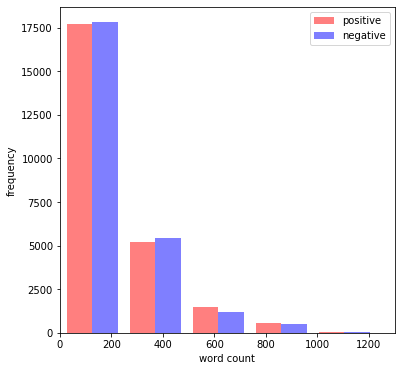

In [28]:
#plotting word count distribution for pos/negative reviews

x = df['word count'][df.sentiment == 1]
y = df['word count'][df.sentiment == 0]
plt.figure(figsize=(6,6))
plt.xlim(0,1300)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x,y], 
             color=['r','b'], 
             alpha=0.5, 
             label=['positive', 'negative'])
plt.legend(loc='upper right')

In [25]:
# Most reviews fall between 100 to 200 words, it was surprising to learn some reviews can be over 800 words
# Up until 600 words negative reviews are longer than positive reviews
# typically negative reviews are longer than positive reviews

In [7]:
#removing html strips

def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

#removing brackets
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#removing noisy text
def noisy_text(text):
    text = strip_html(text)
    text = remove_brackets(text)
    return text

df['review'] = df['review'].apply(noisy_text)

#removing special characters
def remove_special_char(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

df['review'] = df['review'].apply(remove_special_char)


In [8]:
# getting most common words in a training df and showing top 10

all_words = []
for line in list(df['review']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
        
Counter(all_words).most_common(10)

[('the', 650451),
 ('and', 319363),
 ('a', 319177),
 ('of', 288048),
 ('to', 266262),
 ('is', 210034),
 ('in', 183111),
 ('it', 151244),
 ('i', 145447),
 ('this', 145434)]

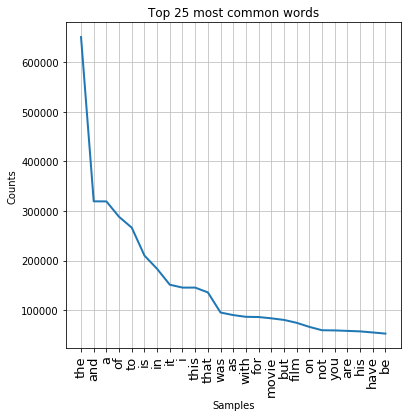

In [9]:
#plotting the frequency of the top 25 most used words

plt.figure(figsize=(6,6))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [10]:
#Creating a list to append words in reviews to exclude stopwords

stop_words = set(stopwords.words('english'))

filtered_words = []
for w in all_words:
    if w not in stop_words:
        filtered_words.append(w)

Counter(filtered_words).most_common(10)

[('movie', 83501),
 ('film', 74459),
 ('one', 50360),
 ('like', 38823),
 ('good', 28479),
 ('even', 24278),
 ('would', 23998),
 ('time', 23264),
 ('really', 22894),
 ('see', 22430)]

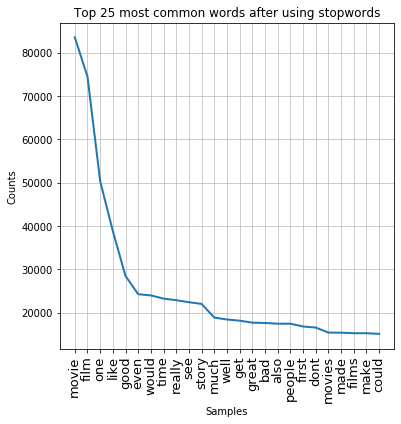

In [11]:
#Plotting to see 25 most common words after using stopwords
plt.figure(figsize=(6,6))
plt.title('Top 25 most common words after using stopwords')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(filtered_words)
fd.plot(25,cumulative=False)

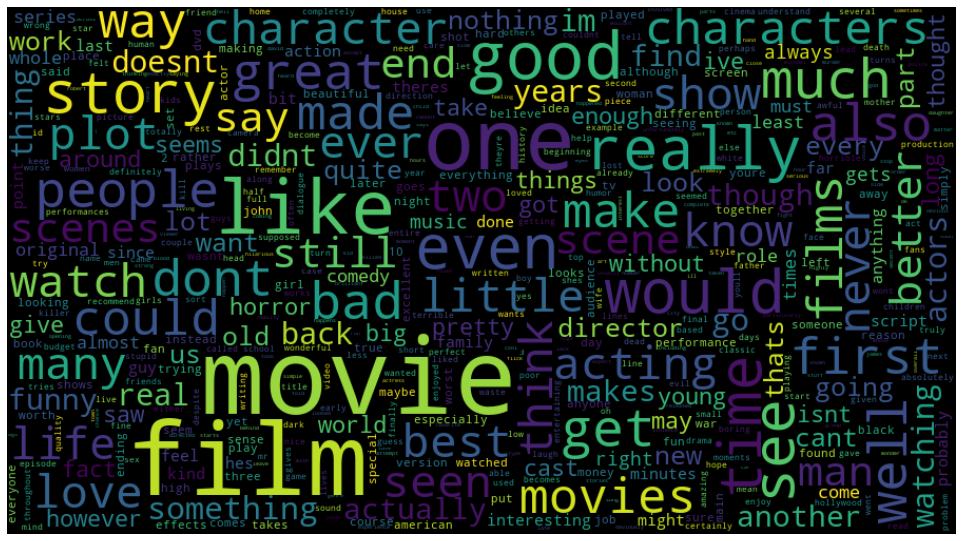

In [24]:
#creating a word cloud of the most frequenty used words
wordfreq = Counter(filtered_words)

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size =0.3, random_state=123)

print(f'Train dimensions: {X_train.shape, y_train.shape}')
print(f'Test dimensions: {X_test.shape, y_test.shape}')

#target distribution
print(y_train.value_counts())
print(y_test.value_counts())

Train dimensions: ((35000,), (35000,))
Test dimensions: ((15000,), (15000,))
0    17531
1    17469
Name: sentiment, dtype: int64
1    7531
0    7469
Name: sentiment, dtype: int64


In [29]:
#Using Vectorization to convert each review into a number
count = CountVectorizer()
words = (filtered_words)
bag = count.fit_transform(words)

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

#removing additionalsymbols left
def preprocessor(text):
  text =re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
  return text

df['review'] = df['review'].apply(preprocessor)

porter = PorterStemmer()

def tokenize(text):
    return text.split()

def tokenizer_stemmer(text):
    return[porter.stem(word) for word in text.split()]
    

In [34]:
#Vectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
                        tokenizer=tokenizer_stemmer,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X = tfidf.fit_transform(X_train)
X.shape

(35000, 142845)

In [16]:
#Building a base model using Stochastic Gradient Descent Classifier

#Creating variables and fitting the into the data

sgd_clf = SGDClassifier(random_state=123)
sgf_clf_scores = cross_val_score(sgd_clf, X, y_train, cv=5)

#finding out the scores and accuracy of the model
print(sgf_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (sgf_clf_scores.mean(), sgf_clf_scores.std() *2))


[0.89 0.9  0.89 0.89 0.89]
Accuracy: 0.89 (+/- 0.01)


In [17]:
cross_val_score(sgd_clf, X, y_train, cv=5, scoring='accuracy')

array([0.89, 0.9 , 0.89, 0.89, 0.89])

In [18]:
#confusion matrix
sgf_clf_pred = cross_val_predict(sgd_clf, X, y_train, cv=5)

#accuracy of predictions
print(confusion_matrix(y_train, sgf_clf_pred))

[[15441  2090]
 [ 1733 15736]]


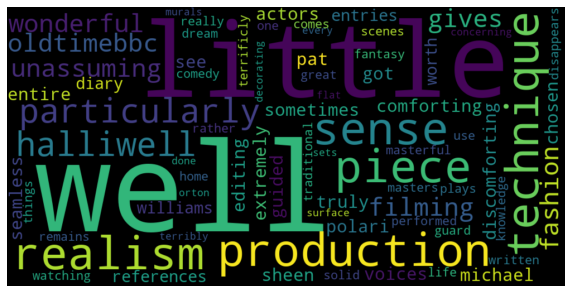

In [31]:
#Creating a positive world cloud

train_reviews = df.review[:35000]
pos_words = train_reviews[1]

WC = WordCloud(width=1000,
               height=500,
               max_words=500,
               min_font_size=5)
plt.figure(figsize=(10,10))
pos_word_cloud = WC.generate(pos_words)
plt.imshow(pos_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

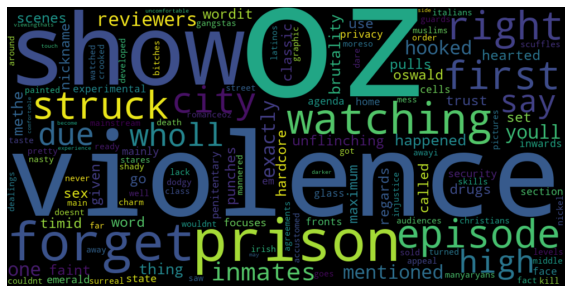

In [32]:
#creating a negative word cloud

train_reviews = df.review[:35000]
neg_words = train_reviews[0]

WC = WordCloud(width=1000,
               height=500,
               max_words=400,
               min_font_size=5)
plt.figure(figsize=(10,10))
neg_word_cloud = WC.generate(neg_words)
plt.imshow(neg_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Sources:
#https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb
#https://towardsdatascience.com/imdb-reviews-or-8143fe57c825
#https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews
#https://towardsdatascience.com/introduction-to-nlp-part-4-supervised-text-classification-model-in-python-96e9709b4267